## Convolutional Autoencoders with diffusion steps

Run the notebook and observe the de-noising output on some test samples (at end).

Try different set of input samples to test

Try this:  go to the cell that sets up the noise, change the "steps2use"  variables, which are the number of de-noising steps to learn.  Learning more steps means smaller changes.  Does a smaller number still work?  


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

2024-06-25 16:33:55.088876: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 16:33:55.125020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 16:33:55.125049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 16:33:55.126023: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-25 16:33:55.131352: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#Here's some helper function to display images

def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, len(disp_images), offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')

def display_inputs(disp_input_images,desc='images'):
  plt.figure(figsize=(15,5))
  print(desc)  #'------------  Input Images --------------')
  display_one_row(disp_input_images, 0, shape=(28,28,))



## Prepare the Dataset

In [3]:
#Load MNIST data from Keras datasets
#   The classes are not used here b/c targets are the original images
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train=X_train[0:1000,]  #only need smaller subset to get good results
X_test =X_test[0:100,]

# --------- Reshape input data, b/c Keras expects N-3D images (ie 4D matrix)
X_train = X_train[:,:,:,np.newaxis]
X_test  = X_test[:,:,:,np.newaxis]

#Scale 0 to 1  
X_train = X_train/255.0
X_test  = X_test/255.0

# ------------- End loading and preparing data --------------
print('X train shape:', X_train.shape) 
print('X test shape:', X_test.shape) 


X train shape: (1000, 28, 28, 1)
X test shape: (100, 28, 28, 1)


In [4]:
#Function to add some noise to make it harder
def addnoise(X,dist2use='norm',mag=1):
        print('args',dist2use,mag)
        if dist2use=='uni':
           X=X + np.round(np.random.uniform(-mag,mag,size=X.shape) )
        if dist2use=='norm':
           X=X + np.round(np.random.normal(0,mag,size=X.shape) ) #mag is std or scale
        X[np.where(X>1)]=1
        X[np.where(X<0)]=0
        return X

def get_interpolations(mag2use,X_train,X_train_wnoise,X_train_prev):
    newb            = 0
    X_endpt_wnoise  = addnoise(X_train,dist2try,mag2use)  

    #for each image get interpolatsions between original and endpoint images
    for b in range(X_train.shape[0]):   #b is index in batch dimension
      #get the difference in bth image 
      X_inter_stepsize = np.divide(np.subtract(X_train[b,],X_endpt_wnoise[b,]), steps2use);            
      X_ithstep        = X_train[b,]
      
      #include the original to oriingal (nothing to denoise) as training example
      X_train_prev[newb,]     = X_ithstep
      #_ithstep               = np.subtract(X_ithstep,X_inter_stepsize);
      X_train_wnoise[newb,]   = X_ithstep 
      newb+=1
      
      for i in range(steps2use):         
         X_train_prev[newb,]     = X_ithstep
         X_ithstep               = np.subtract(X_ithstep,X_inter_stepsize);
         X_train_wnoise[newb,]   = X_ithstep 
         newb+=1
    return X_train_wnoise,X_train_prev

##  Set up the diffusion/incremental noise here.  The steps2use is the T parameter

In [5]:
# Either set up diffusion images or just addnoise
if 1:
  dist2try       ='norm'  # use normal distribution for noise
  mag2use        = 1;     #magnitude of noise, aka scale or standard deviation
  steps2use      = 10;    #number of diffusion steps to mimic   <<<<<--------------------
       
  newN = X_train.shape[0]*(steps2use+1)
  X_temp_wnoise = np.zeros([newN,28,28,1]) # the inputs - allocate arrays to fill in 
  X_temp_prev   = np.zeros([newN,28,28,1]) # the targets

  #noise is added and then interpolated as T steps
  X_train_wnoise_input, X_train_wnoise_target = get_interpolations(mag2use,X_train,X_temp_wnoise,X_temp_prev)

  newN = X_test.shape[0]*(steps2use+1)  
  X_temp_wnoise = np.zeros([newN,28,28,1]) # the inputs
  X_temp_prev   = np.zeros([newN,28,28,1]) # the targets

  X_test_wnoise_input, X_test_wnoise_target = get_interpolations(mag2use,X_test,X_temp_wnoise,X_temp_prev)

    
else:
    X_train_wnoise = addnoise(X_train,dist2use='norm',mag=1)
    X_test_wnoise  = addnoise(X_test,dist2use='norm',mag=1)

print('noise added to train and test')
print(X_train_wnoise_input.shape)
print(X_train_wnoise_target.shape)
print(X_test_wnoise_input.shape)
print(X_test_wnoise_target.shape)


args norm 1
args norm 1
noise added to train and test
(11000, 28, 28, 1)
(11000, 28, 28, 1)
(1100, 28, 28, 1)
(1100, 28, 28, 1)


image indices [ 0  1  2  3  4  5  6  7  8  9 10]
images


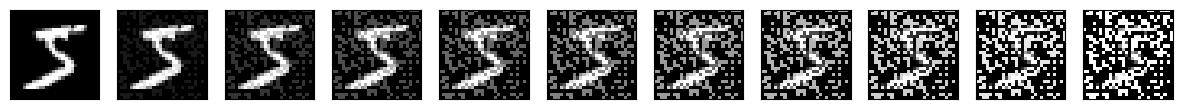

In [6]:
#print a few images
start_ind = 0*(steps2use+1)
idxs      = np.array(np.arange(start_ind,start_ind+steps2use+1))

print('image indices',idxs)
input_samples = np.array(X_train_wnoise_input[idxs])
display_inputs(input_samples)



## Define the Model

This will use convolutional layers to build the model. This is composed of three main parts: encoder, bottleneck, and decoder. You will follow the configuration shown in the image below.

<img src="https://drive.google.com/uc?export=view&id=15zh7bst9KKvciRdCvMAH7kXt3nNkABzO" width="75%" height="75%"/>

The encoder will contract with each additional layer. The features are generated with the Conv2D layers while the max pooling layers reduce the dimensionality.

In [7]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
                                                                     #padding same produces same output size
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1) #max pooling does the downsampling

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2, conv_1, conv_2   #Notice this returns the last layer and intermediate ones

A bottleneck layer is used to get more features but without further reducing the dimension afterwards. Another layer is inserted here for visualizing the encoder output. 

In [8]:
def bottle_neck(inputs):
  '''Defines the bottleneck.''' #how many filters do we need here?
  bottle_neck = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same',name='thebottleneck')(inputs)
    #no maxpooling so no downsampling, 
  
  return bottle_neck

## Add a skip connection with concatenation here 

The decoder will upsample the bottleneck output back to the original image size. 

To add a skip connection, first match up the correct encoding output to the decoding input, so that he feature maps are the same size 

Use the tensorflow concatenation function as described here:

https://keras.io/api/layers/merging_layers/concatenate/

In [9]:
def decoder(inputs, enc_conv1,enc_conv2):
  '''Defines the decoder path to upsample back to the original image size.'''
  #Notice that padding = same keeps the output same size as input 
  
  conv_1      = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  do_skip=1
  if do_skip:
    skip_concat_1 = tf.keras.layers.Concatenate(axis=-1)([up_sample_1, enc_conv2]) 
    conv_2      = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(skip_concat_1)
  else:
    conv_2      = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  

  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)
    
  if do_skip:
    skip_concat_2 = tf.keras.layers.Concatenate(axis=-1)([up_sample_2, enc_conv1])
    conv_3      = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(skip_concat_2)
  else:
    conv_3      = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)


  return conv_3

In [10]:
def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs                                     = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output, enc_conv1_output, enc_conv2_output = encoder(inputs)
  bottleneck_output                          = bottle_neck(encoder_output)
  decoder_output                             = decoder(bottleneck_output, enc_conv1_output, enc_conv2_output)
  
  model         = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  return model



In [11]:
convolutional_model = convolutional_auto_encoder()
convolutional_model.summary() 



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 128)          73856     ['max_pooling2d[0][0]']   

2024-06-25 16:33:59.323606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30953 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


## Compile and Train the model

In [12]:
myES_function = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(X_train_wnoise_input,X_train_wnoise_target, 
                                             validation_data=(X_test_wnoise_input,X_test_wnoise_target),
                                             batch_size=128,
                                             epochs=20,callbacks=[myES_function])


Epoch 1/20


2024-06-25 16:34:01.592278: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
2024-06-25 16:34:03.148120: I external/local_xla/xla/service/service.cc:168] XLA service 0x154a9b4375d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-25 16:34:03.148159: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-06-25 16:34:03.152549: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719358443.284891  777589 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 [==============================] - 6s 15ms/step - loss: 0.3606 - val_loss: 0.2424
Epoch 2/20
86/86 [==============================] - 1s 7ms/step - loss: 0.2132 - val_loss: 0.1985
Epoch 3/20
86/86 [==============================] - 1s 7ms/step - loss: 0.1962 - val_loss: 0.1943
Epoch 4/20
86/86 [==============================] - 1s 7ms/step - loss: 0.1938 - val_loss: 0.1923
Epoch 5/20
86/86 [==============================] - 1s 7ms/step - loss: 0.1922 - val_loss: 0.1910
Epoch 6/20
86/86 [==============================] - 1s 7ms/step - loss: 0.1910 - val_loss: 0.1899
Epoch 7/20
86/86 [==============================] - 1s 7ms/step - loss: 0.1899 - val_loss: 0.1896
Epoch 8/20
86/86 [==============================] - 1s 7ms/step - loss: 0.1893 - val_loss: 0.1883
Epoch 9/20
86/86 [==============================] - 1s 7ms/step - loss: 0.1884 - val_loss: 0.1877
Epoch 10/20
86/86 [==============================] - 1s 7ms/step - loss: 0.1878 - val_loss: 0.1871
Epoch 11/20
86/86 [==========

## Display sample results

As usual, let's see some sample results from the trained model.

---------------- original digits no noise ---------------
images


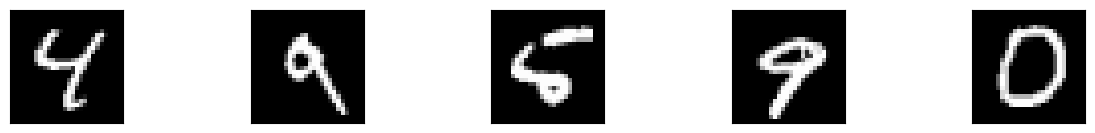

In [13]:
# pick some indices
idxs_orig = np.array([1, 2, 3, 4, 5]) 
idxs_orig = np.array([6, 7, 8, 9,10])
idxs = np.multiply(steps2use+1,idxs_orig)  
       #ie every n+1th image is the original, b/c there are n more noise steps
       #   where n=step2use

testsize = len(idxs)

# prepare test samples as a batch of 10 images
input_samples = np.array(X_test_wnoise_input[idxs])
input_samples = np.reshape(input_samples, (testsize, 28, 28, 1))

# display the samples, encodings and decoded values!
print('---------------- original digits no noise ---------------')
display_inputs(input_samples)


1/1 [==============================] - 0s 249ms/step
------------ images with some noise -----------------------
images


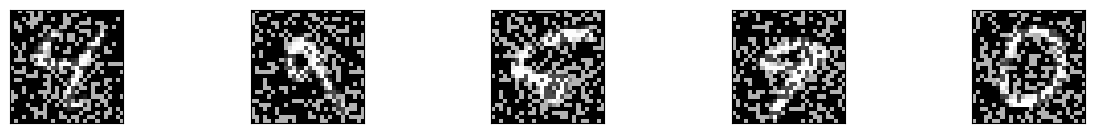

In [14]:
#now pick out the images with some noise, eg 7th after every 11th image (try 10 or 2?)
idxs = np.add(7,np.multiply(steps2use+1,idxs_orig))

# prepare test samples as a batch of images
input_samples = np.array(X_test_wnoise_input[idxs])
input_samples = np.reshape(input_samples, (testsize, 28, 28, 1))

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(input_samples)

# display the samples, encodings and decoded values!
print('------------ images with some noise -----------------------')
display_inputs(input_samples)


---------------- after 1 diffusion step ----------------------
images


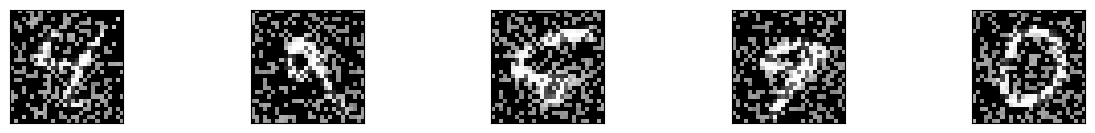

In [15]:
# display the reconsstructed images
print('---------------- after 1 diffusion step ----------------------')
#display_predicted(predicted)
display_inputs(predicted)


1/1 [==============================] - 0s 15ms/step
images
 -------------- 0   -----------------
1/1 [==============================] - 0s 14ms/step
images
 -------------- 1   -----------------
1/1 [==============================] - 0s 14ms/step
images
 -------------- 2   -----------------
1/1 [==============================] - 0s 14ms/step
images
 -------------- 3   -----------------
1/1 [==============================] - 0s 15ms/step
images
 -------------- 4   -----------------
1/1 [==============================] - 0s 15ms/step
images
 -------------- 5   -----------------
1/1 [==============================] - 0s 15ms/step
images
 -------------- 6   -----------------
1/1 [==============================] - 0s 14ms/step
images
 -------------- 7   -----------------
1/1 [==============================] - 0s 14ms/step
images
 -------------- 8   -----------------
1/1 [==============================] - 0s 14ms/step
images
 -------------- 9   -----------------
1/1 [=========================

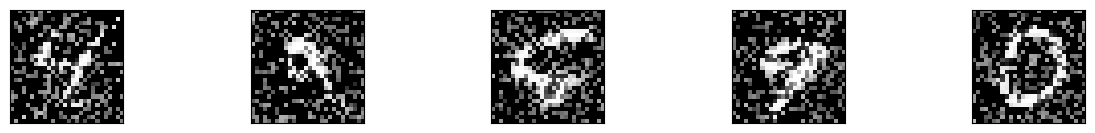

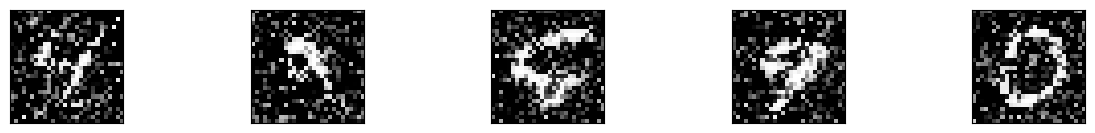

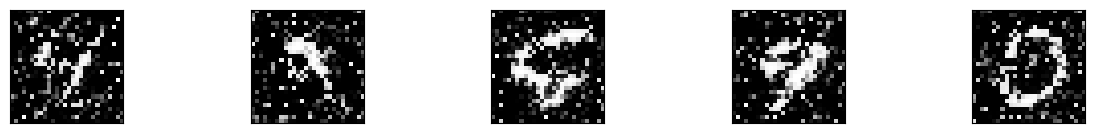

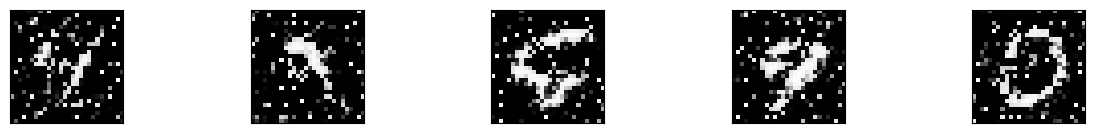

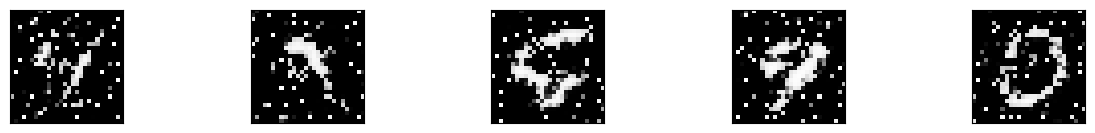

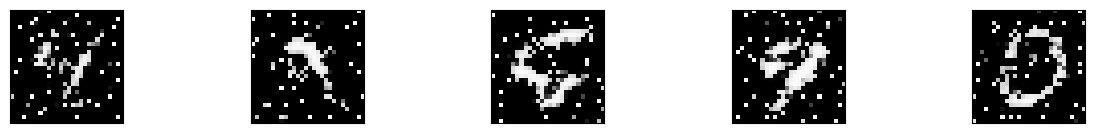

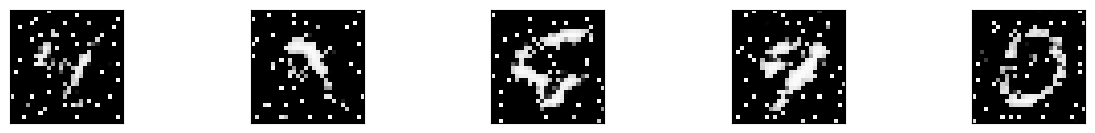

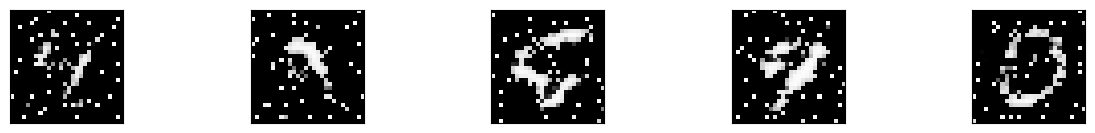

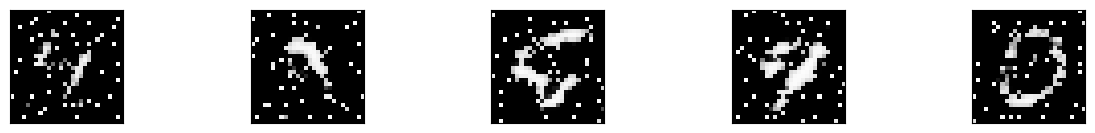

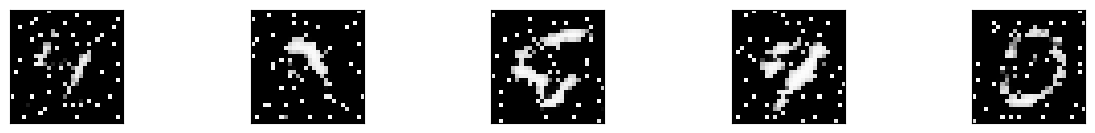

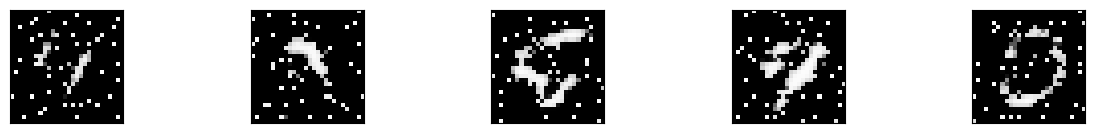

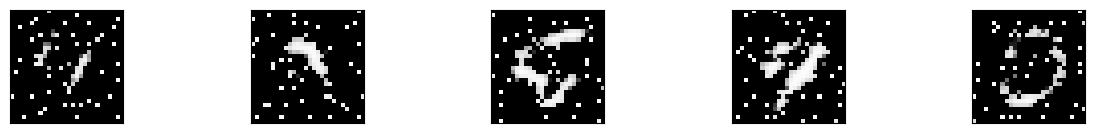

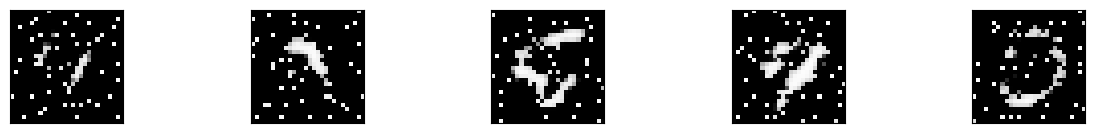

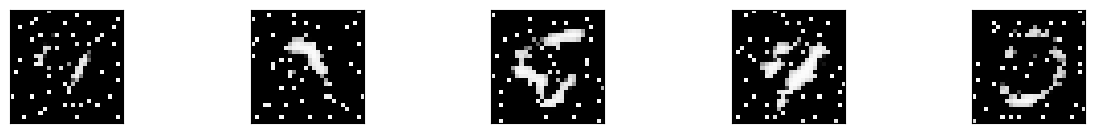

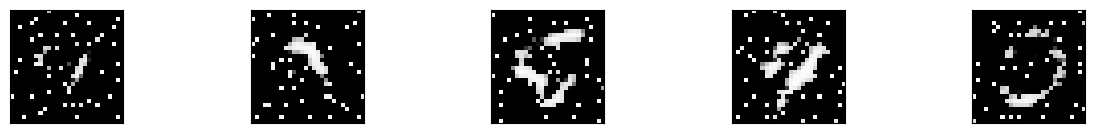

In [16]:
#now print all steps and a few more
for i in range(15):
  input_samples=predicted;
  predicted = convolutional_model.predict(input_samples)
  display_inputs(predicted)
  print(' --------------', i, '  -----------------')